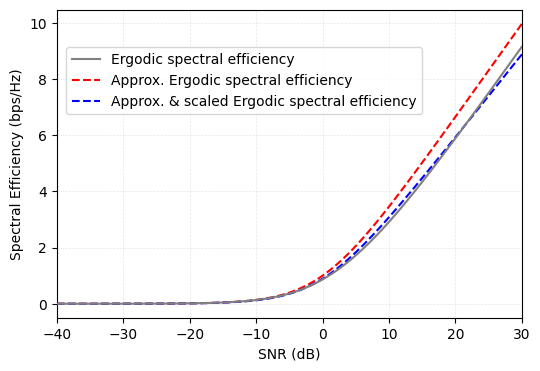

In [8]:
import numpy as np
import matplotlib.pyplot as plt

SNR_range = [-40, 30]
SNR_values = np.linspace(SNR_range[0], SNR_range[1], 100)

num_experiments = 10000

def db_to_linear(snr):
    return 10 ** (snr / 10)

def spectral_efficiency(snr, fading=1):
    return np.log2(1 + db_to_linear(snr)*fading)

avg_spectral_efficiency = 0
for _ in range(num_experiments):
    fading = np.random.exponential(scale=1)  # Rayleigh fading
    avg_spectral_efficiency += spectral_efficiency(SNR_values, fading)
avg_spectral_efficiency /= num_experiments

# Compare this with unit fading channel in plot
plt.figure(figsize=(6, 4))
plt.plot(SNR_values, avg_spectral_efficiency, label='Ergodic spectral efficiency', color='grey', zorder=10)
plt.plot(SNR_values, spectral_efficiency(SNR_values), label='Approx. Ergodic spectral efficiency', color='red', linestyle='--')
plt.plot(SNR_values, spectral_efficiency(SNR_values)*.8908, label='Approx. & scaled Ergodic spectral efficiency', color='blue', linestyle='--')
plt.xlim(SNR_range)
# plt.ylim([-0.1, 4.3])
# plt.yticks(np.linspace(0,4,5))
# plt.xticks(np.linspace(-30,10,5))
plt.xlabel('SNR (dB)')
plt.ylabel('Spectral Efficiency (bps/Hz)')
plt.legend(bbox_to_anchor=(0.8, 0.9))
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.3)
# EPS
plt.savefig('ergodic_spectral_efficiency.pdf', dpi=300, bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Optimal scale alpha*: 0.890831
MSE at alpha*:       8.025327e-03


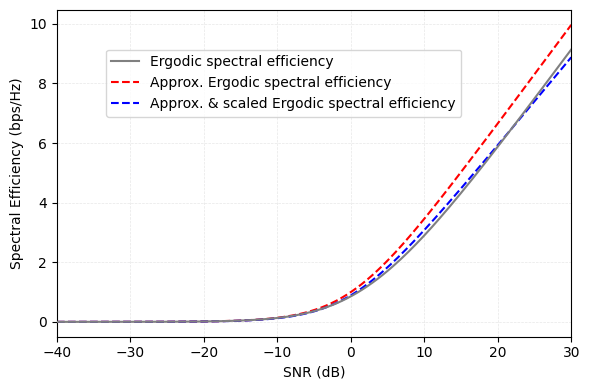

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Configuration
# -----------------------------
SNR_range = [-40, 30]               # dB range for fitting
n_snr = 200                         # number of SNR samples on the grid
num_experiments = 20000             # Monte Carlo trials for ergodic averaging
rng_seed = 0                        # for reproducibility; set None for random

# -----------------------------
# Helpers
# -----------------------------
def db_to_linear(snr_db):
    # Convert SNR in dB to linear scale
    return 10.0 ** (snr_db / 10.0)

def spectral_efficiency_no_fade(snr_db):
    # Unit-fading (no fading) spectral efficiency: log2(1 + SNR)
    snr_lin = db_to_linear(np.asarray(snr_db))
    return np.log2(1.0 + snr_lin)

def ergodic_spectral_efficiency_rayleigh(snr_db, num_mc=10000, seed=None):
    # Monte Carlo estimate of E[log2(1 + SNR * |h|^2)] with |h|^2 ~ Exp(1)
    snr_lin = db_to_linear(np.asarray(snr_db)).reshape(1, -1)  # shape (1, n_snr)
    rng = np.random.default_rng(seed)
    # Rayleigh power gain |h|^2 ~ Exp(1); draw (num_mc, 1) to broadcast over SNR grid
    fading_power = rng.exponential(scale=1.0, size=(num_mc, 1))
    # Compute log2(1 + SNR * fading) and average over Monte Carlo dimension
    se = np.log2(1.0 + snr_lin * fading_power)
    return se.mean(axis=0)  # shape (n_snr,)

def fit_scale_mse(x, y, w=None):
    # Solve argmin_alpha sum_i w_i * (y_i - alpha * x_i)^2
    # Closed-form: alpha* = (x^T W y) / (x^T W x)
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    if w is None:
        num = np.dot(x, y)
        den = np.dot(x, x)
    else:
        w = np.asarray(w).ravel()
        num = np.dot(w * x, y)
        den = np.dot(w * x, x)
    alpha = 0.0 if den == 0 else num / den
    mse = np.mean((y - alpha * x) ** 2) if w is None else np.average((y - alpha * x) ** 2, weights=w)
    return alpha, mse

# -----------------------------
# Compute curves
# -----------------------------
SNR_values = np.linspace(SNR_range[0], SNR_range[1], n_snr)

# Target (ergodic) curve via Monte Carlo
avg_spectral_efficiency = ergodic_spectral_efficiency_rayleigh(
    SNR_values, num_mc=num_experiments, seed=rng_seed
)

# Regressor curve (no-fading)
se_no_fade = spectral_efficiency_no_fade(SNR_values)

# -----------------------------
# Fit best scale alpha (MSE)
# -----------------------------
alpha_star, mse_star = fit_scale_mse(se_no_fade, avg_spectral_efficiency)

print(f"Optimal scale alpha*: {alpha_star:.6f}")
print(f"MSE at alpha*:       {mse_star:.6e}")

# -----------------------------
# Plot
# -----------------------------
# Compare this with unit fading channel in plot
plt.figure(figsize=(6, 4))
plt.plot(SNR_values, avg_spectral_efficiency, label='Ergodic spectral efficiency', color='grey', zorder=10)
plt.plot(SNR_values, se_no_fade, label='Approx. Ergodic spectral efficiency', color='red', linestyle='--')
plt.plot(SNR_values, alpha_star * se_no_fade, label='Approx. & scaled Ergodic spectral efficiency', color='blue', linestyle='--')

plt.xlim(SNR_range)
plt.xlabel('SNR (dB)')
plt.ylabel('Spectral Efficiency (bps/Hz)')
plt.legend(bbox_to_anchor=(0.8, 0.9))
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.savefig('ergodic_spectral_efficiency.eps', dpi=300, bbox_inches='tight')
plt.show()


